## Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

## Load files

In [2]:
electric = pd.read_csv("Full Eletric Interval 042016.csv")

In [3]:
electric['Datetime'] = pd.to_datetime(electric['Date'] + ' ' + electric['Start Time'])

In [4]:
propertyCode = pd.read_excel("SIMS_Property_List_4-6-2016_Revised.xlsx")

In [5]:
weather = pd.read_csv('weather_prepared_final.csv')

In [6]:
weather.DATE = pd.to_datetime(weather.DATE)

### List of codes

In [7]:
codelist = [b[0] for b in electric['Meter'].str.split()]

In [8]:
codes = pd.Series(codelist)

### Usage by day

In [9]:
electric_date_full = electric
electric_date_full.Datetime = electric_date_full.Datetime.dt.date

In [10]:
electric_day = electric_date_full.drop('Temperature', 1).groupby(by=['Meter', 'Datetime']).sum()

### Temperature

In [11]:
temperature = weather.drop(['HUMIDITY', 'LON', 'LAT', 'STATION'], 1).iloc[1::4, :]

### Daily average temperature

In [12]:
daily_temperature = temperature
daily_temperature.DATE = temperature.DATE.dt.date
daily_temperature = daily_temperature.groupby(by='DATE').mean()

## Functions

In [13]:
def normal_usage(meter, date, temperature):
    weekend = pd.to_datetime(date).weekday in [5,6]
    meter_usage = electric_day.ix[meter]
    return meter_usage[(daily_temperature.ix[meter_usage.index]['TEMPERATURE'] > temperature - 4) & (daily_temperature.ix[meter_usage.index] < temperature + 4).squeeze() & (abs(pd.to_datetime(date).dayofyear - pd.to_datetime(meter_usage.index).dayofyear) < 20) & (pd.to_datetime(meter_usage.index).weekday.isin([5,6]) == weekend)]['Usage'].mean()

In [14]:
def percent_difference(meter, date, temperature, usage):
    normal = normal_usage(meter, date, temperature)
    if usage > 100:
        if normal == 0:
            normal = 1
        return 100 * (usage - normal) / normal
    return float('nan')

In [15]:
def percent_diff_lst(meter):
    dates = pd.to_datetime(electric_day.ix[meter].index)
    start = pd.to_datetime('2015-01-01')
    end = pd.to_datetime('2016-04-10')
    electric_day_temp = electric_day.ix[meter][(dates >= start) & (dates <= end)]
    diff_lst = []
    date_lst = []
    for day in electric_day_temp.index:
        temperature = daily_temperature.ix[pd.to_datetime(day).date()]
        usage = electric_day_temp.ix[pd.to_datetime(day).date()]
        diff = percent_difference(meter, day.strftime('%Y-%m-%d'), float(temperature), float(usage))
        diff_lst.append(diff)
        date_lst.append(day)
    return pd.DataFrame(diff_lst, date_lst, ['Percent Difference'])

In [16]:
def anomalies(meter):
    diff = percent_diff_lst(meter)
    return diff[diff['Percent Difference'] > 12]

In [17]:
def large_anomalies(meter):
    diff = percent_diff_lst(meter)
    return diff[diff['Percent Difference'] > 50]

In [18]:
def anomaly_groups(meter):
    anom = anomalies(meter)
    dates = []
    for i in anom.index:
        for j in anom.index:
            distance = abs(pd.to_datetime(i).dayofyear - pd.to_datetime(j).dayofyear)
            if (distance < 14) & (distance > 0):
                dates.append(i)
    unique_dates = pd.Series(dates).unique()
    return unique_dates

In [40]:
def single_building_meters_overlay(code, start=pd.to_datetime('2014-04-11 23:30:00').date(), end=pd.to_datetime('2016-04-10 23:30:00').date()):
    meterdf = electric[codes.isin([code])].groupby(by=['Meter', 'Datetime']).mean().unstack('Meter')
    meterdf = meterdf[(meterdf.index >= start) & (meterdf.index <= end)]
    meterdf.plot(y='Usage', figsize=(20,10))
    plt.ylabel('Usage (kWh)')
    plt.title(code)

## BSLC

/usr/local/conda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


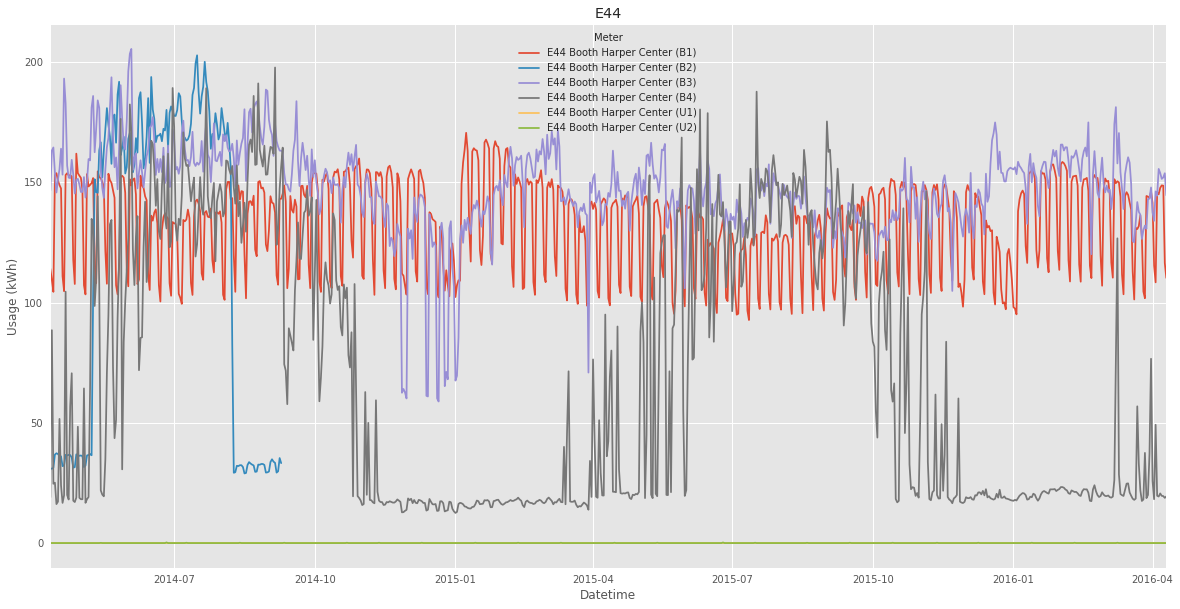

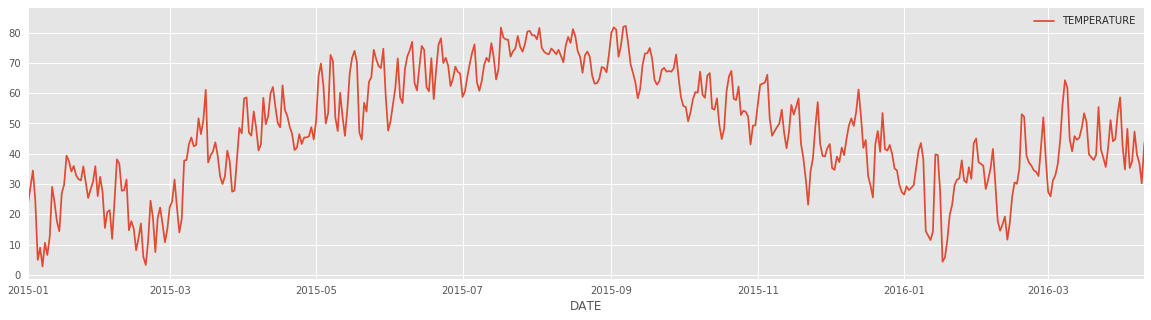

In [41]:
single_building_meters_overlay('E44')
daily_temperature.plot(figsize = (20,5), xlim=(pd.to_datetime('2015-01-01').date(), pd.to_datetime('2016-04-10')))

### B4

In [28]:
anomalies('E44 Booth Harper Center (B4)')

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  
/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if __name__ == '__main__':
/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # Remove the CWD from sys.path while we load stuff.


,Percent Difference
2015-03-13,17.193706
2015-03-15,51.673973
2015-03-30,33.881250
2015-04-01,17.302485
2015-04-05,67.696100
2015-04-06,24.182182
2015-04-09,48.011278
2015-04-10,48.276825
2015-04-11,42.145422
2015-04-17,20.613621


In [29]:
large_anomalies('E44 Booth Harper Center (B4)')

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # Remove the CWD from sys.path while we load stuff.


,Percent Difference
2015-03-15,51.673973
2015-04-05,67.696100
2015-05-14,61.799877
2016-03-23,61.973947
2016-04-03,107.642559


In [30]:
anomaly_groups('E44 Booth Harper Center (B4)')

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # Remove the CWD from sys.path while we load stuff.


array([datetime.date(2015, 3, 13), datetime.date(2015, 3, 15),
       datetime.date(2015, 3, 30), datetime.date(2015, 4, 1),
       datetime.date(2015, 4, 5), datetime.date(2015, 4, 6),
       datetime.date(2015, 4, 9), datetime.date(2015, 4, 10),
       datetime.date(2015, 4, 11), datetime.date(2015, 4, 17),
       datetime.date(2015, 5, 6), datetime.date(2015, 5, 8),
       datetime.date(2015, 5, 11), datetime.date(2015, 5, 14),
       datetime.date(2015, 6, 2), datetime.date(2015, 6, 3),
       datetime.date(2015, 6, 10), datetime.date(2015, 6, 15),
       datetime.date(2015, 6, 26), datetime.date(2015, 10, 3),
       datetime.date(2015, 10, 5), datetime.date(2015, 10, 6),
       datetime.date(2015, 10, 7), datetime.date(2015, 11, 5),
       datetime.date(2015, 11, 6), datetime.date(2015, 11, 11),
       datetime.date(2015, 11, 18), datetime.date(2016, 1, 18),
       datetime.date(2016, 1, 19), datetime.date(2016, 1, 20),
       datetime.date(2016, 1, 21), datetime.date(2016, 1, 26)

### B3

In [31]:
anomalies('E44 Booth Harper Center (B3)')

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # Remove the CWD from sys.path while we load stuff.


,Percent Difference
2015-03-07,15.951766
2015-03-09,15.508096
2015-10-22,15.053946
2015-12-17,12.133339
2015-12-18,21.014550
2015-12-19,22.055608
2015-12-20,28.660777
2015-12-21,25.371986
2015-12-22,13.697093
2015-12-24,13.844172


In [32]:
large_anomalies('E44 Booth Harper Center (B4)')

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # Remove the CWD from sys.path while we load stuff.


,Percent Difference
2015-03-15,51.673973
2015-04-05,67.696100
2015-05-14,61.799877
2016-03-23,61.973947
2016-04-03,107.642559


In [33]:
anomaly_groups('E44 Booth Harper Center (B4)')

/usr/local/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # Remove the CWD from sys.path while we load stuff.


array([datetime.date(2015, 3, 13), datetime.date(2015, 3, 15),
       datetime.date(2015, 3, 30), datetime.date(2015, 4, 1),
       datetime.date(2015, 4, 5), datetime.date(2015, 4, 6),
       datetime.date(2015, 4, 9), datetime.date(2015, 4, 10),
       datetime.date(2015, 4, 11), datetime.date(2015, 4, 17),
       datetime.date(2015, 5, 6), datetime.date(2015, 5, 8),
       datetime.date(2015, 5, 11), datetime.date(2015, 5, 14),
       datetime.date(2015, 6, 2), datetime.date(2015, 6, 3),
       datetime.date(2015, 6, 10), datetime.date(2015, 6, 15),
       datetime.date(2015, 6, 26), datetime.date(2015, 10, 3),
       datetime.date(2015, 10, 5), datetime.date(2015, 10, 6),
       datetime.date(2015, 10, 7), datetime.date(2015, 11, 5),
       datetime.date(2015, 11, 6), datetime.date(2015, 11, 11),
       datetime.date(2015, 11, 18), datetime.date(2016, 1, 18),
       datetime.date(2016, 1, 19), datetime.date(2016, 1, 20),
       datetime.date(2016, 1, 21), datetime.date(2016, 1, 26)